In [274]:
import numpy as np
import torch
from diffusers import KandinskyV22InpaintCombinedPipeline
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation, AutoModelForImageClassification, pipeline, \
    AutoImageProcessor, MobileViTV2ForImageClassification

from models.combined_pipeline import CombinedPipeline
from diffusers.utils import make_image_grid, numpy_to_pil



In [275]:
# pipe = KandinskyV22InpaintCombinedPipeline.from_pretrained('kandinsky-community/kandinsky-2-2-decoder-inpaint', torch_dtype=torch.float16)
segmentation_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
segmentation_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").cuda()
classifier_processor = AutoImageProcessor.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
classifier_model = MobileViTV2ForImageClassification.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
# classifier = pipeline('image-classification',
#                       model=classifier_model,
#                       image_processor=classifier_processor)

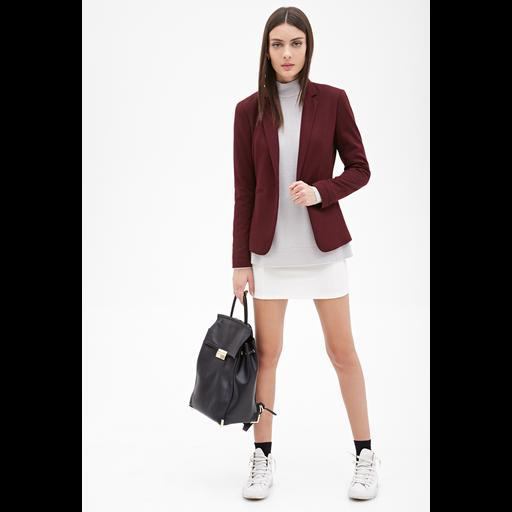

In [300]:
from PIL import Image
source_image = Image.open('../cache/in/image3.png')
threshold = 0.1
prompt = ['shirt', 'pants', 'shorts', 'shoes', 't-shirt',
          'sweatshirt', "cowboy boot", "cowboy hat",
          'crash helmet', 'cardigan', 'blouse', 'jacket', 'jeans',]
negative_prompt = ['head, neck', 'hair', 'face', 'hand',]
# text = ['human body, clothes', 'head, hair', 'hand, arm', 'open skin']
source_image

In [301]:
import numpy as np

def get_masks(image, prompts):
    inputs = segmentation_processor(
        text=prompts,
        images=[image] * len(prompts), padding="max_length", return_tensors="pt"
    ).to(device='cuda')
    inputs['pixel_values'] = inputs['pixel_values'].to(dtype=segmentation_model.dtype)
    outputs = segmentation_model(**inputs)

    _masks = []
    _mask = np.zeros(tuple(outputs.logits[0].shape) + (1,))
    for logits in outputs.logits:
        m = torch.sigmoid(logits).cpu().detach().unsqueeze(-1).numpy()
        m[m < threshold] = 0
        m[m >= threshold] = 1
        _mask += m
        _masks.extend(numpy_to_pil(m))
    _masks.extend(numpy_to_pil(_mask))
    return _masks, _mask

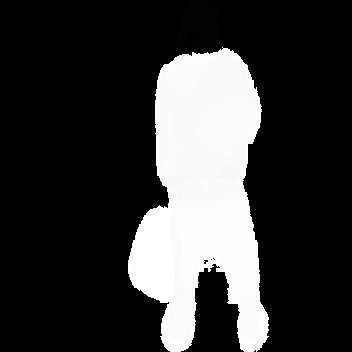

In [302]:
masks, mask = get_masks(source_image, prompt)
negative_masks, negative_mask = get_masks(source_image, negative_prompt)
numpy_to_pil(mask - negative_mask)[0]

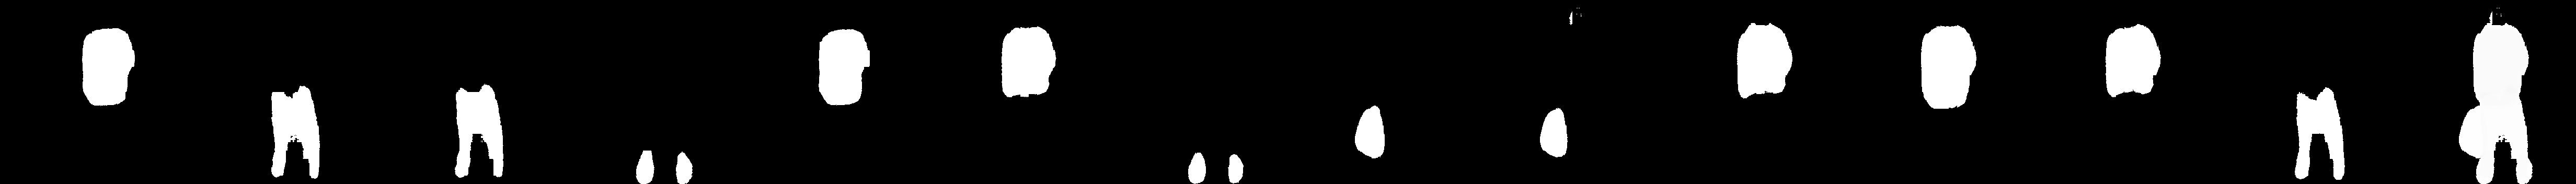

In [303]:
make_image_grid(masks, 1, len(masks))

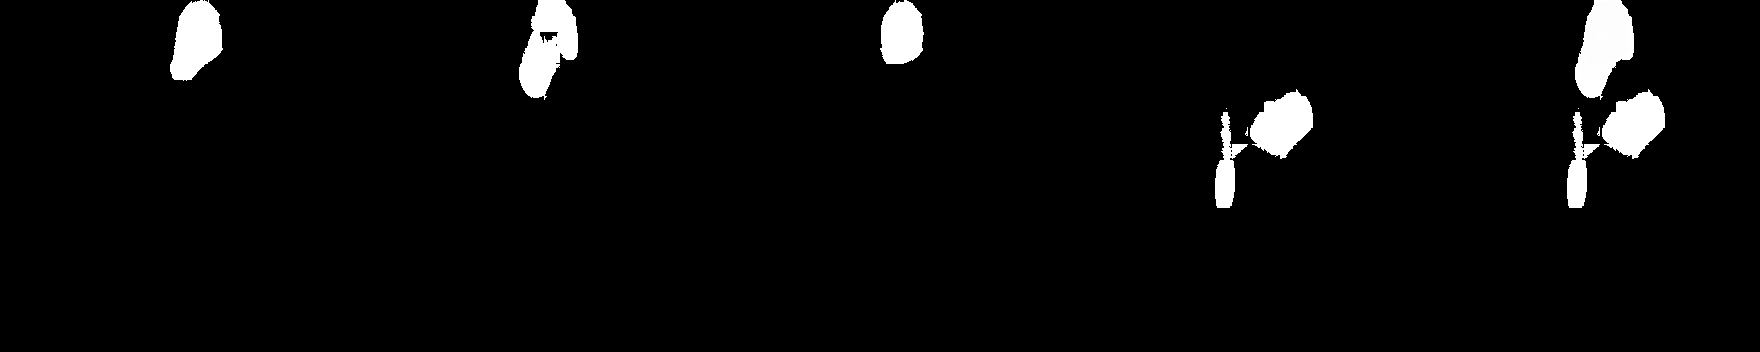

In [304]:
make_image_grid(negative_masks, 1, len(negative_masks))

In [81]:
# CombinedPipeline(
#     unet=pipe.unet,
#     scheduler=pipe.scheduler,
#     movq=pipe.movq,
#     image_encoder=pipe.prior_image_encoder,
#     image_processor=pipe.prior_image_processor,
#     segmentation_processor=segmentation_processor,
#     segmentation_model=segmentation_model,
#     classifier_processor=classifier_processor,
#     classifier_model=classifier_model
# ).save_pretrained('../models/weights/img2img-painting')

In [82]:
# pipe = CombinedPipeline.from_pretrained('../models/weights/img2img-painting', torch_dtype=torch.float16, variant='fp16', use_safetensors=True)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]